Useful stuff
===

In [1]:
class AttributeDict(dict):
    """Like dict but with attribute access and setting"""
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

class inference_score():
    def __init__(self, y, y_hat):
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
        self.dict = AttributeDict(
            accuracy_score=accuracy_score(y, y_hat),
            f1_score=f1_score(y, y_hat),
            recall_score=recall_score(y, y_hat),
            precision_score=precision_score(y, y_hat)
        )
    
    def __str__(self):
        s = ""
        s += f"accuracy       : {self.dict.accuracy_score:.2f}\n"
        s += f"f1 score       : {self.dict.f1_score:.2f}\n"
        s += f"recall score   : {self.dict.recall_score:.2f}\n"
        s += f"precision score: {self.dict.precision_score:.2f}\n"
        return s

    def __repr__(self):
        return str(self)


Get the dataset + TaggedDocuments 
===

Get a Dataframe with all train and test sentences
---

In [2]:
import os
import numpy as np
import pandas as pd
from multiprocessing import Pool
from part2_utils import *


# Directory containing all train and test csv
dataset_dir = os.path.join(os.curdir, 'datasets', 'comments')

DEFAULT_COLUMNS = ["sentence", "class", "class_idx"]
dataset = AttributeDict(
    train=pd.DataFrame(columns=DEFAULT_COLUMNS),
    test=pd.DataFrame(columns=DEFAULT_COLUMNS)
)

classes = {
        "Donald Trump" : "Donald-Trump-%s.csv",
        "Joe Biden" : "Joe-Biden-%s.csv"
        }


for typ in dataset.keys(): # train, test
    for class_idx, (class_name, class_path) in enumerate(classes.items()): # Donald Trump, Joe Biden
        df = pd.read_csv(os.path.join(dataset_dir, class_path%typ), index_col=0)
        df["class"] =  class_name # Get the name (Donald Trump or Joe Biden)
        df["class_idx"] = class_idx # 0 -> Donald Trump, 1 -> Joe Biden
        df.columns = DEFAULT_COLUMNS # Force columns name
        dataset[typ] = dataset[typ].append(df, ignore_index=True) # Append train from Donald and Joe together (the same for test)

assert dataset.train.shape[1:] == (3,), "dataframe does not contain 3 columns named %s"%DEFAULT_COLUMNS
assert dataset.test.shape[1:] == (3,), "dataframe does not contain 3 columns named %s"%DEFAULT_COLUMNS

print(f'Number of words in our train dataset : {dataset.train.sentence.apply(lambda x:len(x.split(" "))).sum():.3e}')

Number of words in our train dataset : 7.084e+05


Retrieve TaggedDocuments from the text embeddings part
---

In [3]:
for typ in ("train", "test"):
    df_preprocess(dataset[typ], "sentence", inplace=True) # Preprocess strings
    df_make_doc(dataset[typ], inplace=True) # Get TaggedDocument for each row

Get the embedding vectors for each model
===

- Get X_train, y_train, X_test, y_test
- MinMax scale inputs

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_precision_recall_curve

X_train_doc = X_train_bert = ... # Depend the output (vector) of the model chosen
y_train = dataset.train.class_idx.values.astype(np.uint8) # sparse categories
X_test_doc = X_test_bert = ... # Depend the output (vector) of the model chosen
y_test  = dataset.test.class_idx.values.astype(np.uint8) # sparse categories

print(f"len of the train set : {len(y_train)}")
print(f"len of the test set  : {len(y_test)}")
print(f"percentage train set : {len(y_train) / (len(y_train) + len(y_test)):.2f}")

len of the train set : 22570
len of the test set  : 5644
percentage train set : 0.80


Doc2Vec model
---

In [5]:
from gensim.models.doc2vec import Doc2Vec

doc2vec_path = os.path.join(os.curdir, "models")
doc2vec_fname = "doc2vec-dims_200-min_count_2-window_2-epochs_50_BEST.model"
doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_path, doc2vec_fname), mmap='r')
doc2vec_model.delete_temporary_training_data(keep_doctags_vectors=False, keep_inference=True)

def infer_vector_worker(doc):
    return doc2vec_model.infer_vector(doc.words)

with Pool() as pool:
    X_train_doc = np.array(pool.map(infer_vector_worker, dataset.train.doc.values))
    X_test_doc = np.array(pool.map(infer_vector_worker, dataset.test.doc.values))

scaler_doc = MinMaxScaler() # min=0., max=1.
X_train_doc = scaler_doc.fit_transform(X_train_doc)
X_test_doc = scaler_doc.transform(X_test_doc) 

BERT model
---

In [6]:
from sentence_transformers import SentenceTransformer

bert = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

X_train_bert = bert.encode(dataset.train.sentence.values, num_workers=2)
bert.eval() # Evaluation mode from torch
X_test_bert = bert.encode(dataset.test.sentence.values, num_workers=2)

scaler_bert = MinMaxScaler() # min=0., max=1.
X_train_bert = scaler_bert.fit_transform(X_train_bert)
X_test_bert = scaler_bert.transform(X_test_bert) 

Random Forest Classifier
===

- Train on the train set
- F1, accuracy, recall and precision on the test set

In [7]:
from sklearn.ensemble import RandomForestClassifier

N_ESTIMATORS = 100

On the Doc2Vec model
---

### Train

In [8]:
rf_classifier_doc = RandomForestClassifier(
    n_estimators=100,
    #warm_start=True, 
    #max_depth=11, 
    #max_leaf_nodes=None,
    # min_samples_leaf=200,
    #max_features=100,
    n_jobs=-1)

rf_classifier_doc.fit(X_train_doc, y_train)

RandomForestClassifier(n_jobs=-1)

### Infer results 

accuracy       : 0.82
f1 score       : 0.81
recall score   : 0.80
precision score: 0.83



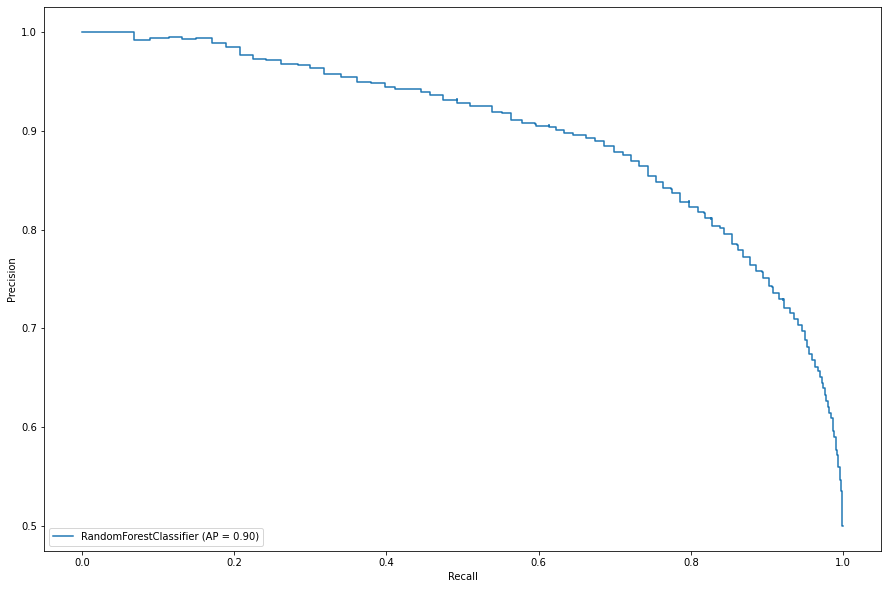

In [9]:
y_hat_doc = rf_classifier_doc.predict(X_test_doc)

print(inference_score(y_test, y_hat_doc))
disp = plot_precision_recall_curve(rf_classifier_doc, X_test_doc, y_test)
disp.figure_.set_size_inches(15, 10)

On the BERT model
---

### Train

In [10]:
rf_classifier_bert = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    n_jobs=-1
)

rf_classifier_bert.fit(X_train_bert, y_train)

RandomForestClassifier(n_jobs=-1)

### Infer results

accuracy       : 0.79
f1 score       : 0.79
recall score   : 0.78
precision score: 0.79



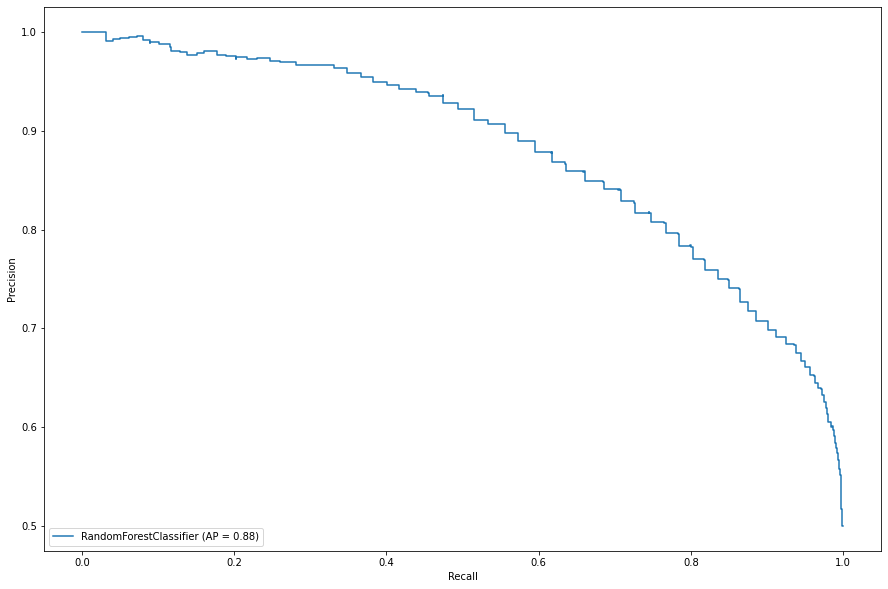

In [11]:
y_hat_bert = rf_classifier_bert.predict(X_test_bert)

print(inference_score(y_test, y_hat_bert))
disp = plot_precision_recall_curve(rf_classifier_bert, X_test_bert, y_test)
disp.figure_.set_size_inches(15, 10)

Linear NN classifier
===

- Train on the train set
- F1, accuracy, recall and precision on the test set

In [12]:
import tensorflow as tf

def get_model(embedding_dims):
    net = tf.keras.models.Sequential(
            [
                tf.keras.layers.Input(shape=(embedding_dims,)),
                tf.keras.layers.Dense(512, activation='relu'),
                tf.keras.layers.Dense(256, activation='relu'),
                tf.keras.layers.Dense(128, activation='relu'),
                #tf.keras.layers.Dropout(.25),
                tf.keras.layers.Dense(1, activation='sigmoid'),  
            ]
        )
    
    return net


Doc2Vec model
---

### Hyper parameters

In [13]:
DOC_HPARAMS = AttributeDict(
    LR=1e-4,
    BATCH_SIZE=64,
    EPOCHS=10,
    EMB_DIMS=200,
)

DOC_PATH = f"./models/lc_doc-emb_dim_{DOC_HPARAMS.EMB_DIMS}-lr_{DOC_HPARAMS.LR}-epochs_{DOC_HPARAMS.EPOCHS}.h5"

### Train

In [14]:
LC_doc = get_model(DOC_HPARAMS.EMB_DIMS)

LC_doc.compile(
            optimizer=tf.keras.optimizers.Adam(lr=DOC_HPARAMS.LR),
            loss=tf.keras.losses.binary_crossentropy,
            metrics=['accuracy']
        )
LC_doc.summary()

LC_doc.fit(
    X_train_doc, y_train,
    validation_data=(X_test_doc, y_test),
    batch_size=DOC_HPARAMS.BATCH_SIZE,
    epochs=DOC_HPARAMS.EPOCHS
)

LC_doc.save(DOC_PATH)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               102912    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 267,265
Trainable params: 267,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
353/353 [==============================] - 1s 4ms/step - loss: 0.6069 - accuracy: 0.6758 - val_loss: 0.5122 - val_accuracy: 0.7769

### Infer results

In [15]:
LC_doc = tf.keras.models.load_model(DOC_PATH)

y_hat_doc = LC_doc.predict(X_test_doc).round()

print(inference_score(y_test, y_hat_doc))

accuracy       : 0.78
f1 score       : 0.75
recall score   : 0.65
precision score: 0.88



BERT model
---

### Hyper parameters

In [16]:
BERT_HPARAMS = AttributeDict(
    LR=1e-4,
    BATCH_SIZE=64,
    EPOCHS=10,
    EMB_DIMS=768
)

BERT_PATH = f"./models/lc_bert-emb_dim_{BERT_HPARAMS.EMB_DIMS}-lr_{BERT_HPARAMS.LR}-epochs_{BERT_HPARAMS.EPOCHS}.h5"

### Train

In [20]:
LC_bert = get_model(BERT_HPARAMS.EMB_DIMS)

LC_bert.compile(
            optimizer=tf.keras.optimizers.Adam(lr=BERT_HPARAMS.LR),
            loss=tf.keras.losses.binary_crossentropy,
            metrics=['accuracy']
        )
LC_bert.summary()

LC_bert.fit(
    X_train_bert, y_train,
    validation_data=(X_test_bert, y_test),
    batch_size=BERT_HPARAMS.BATCH_SIZE,
    epochs=BERT_HPARAMS.EPOCHS
)

LC_bert.save(BERT_PATH)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               393728    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 558,081
Trainable params: 558,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
353/353 [==============================] - 2s 4ms/step - loss: 0.5509 - accuracy: 0.7187 - val_loss: 0.4777 - val_accuracy: 0.7707

### Infer results

In [21]:
LC_bert = tf.keras.models.load_model(BERT_PATH)

y_hat_bert = LC_bert.predict(X_test_bert).round()

print(inference_score(y_test, y_hat_bert))

accuracy       : 0.78
f1 score       : 0.75
recall score   : 0.64
precision score: 0.89

